# Product Recommendation from Basket Data using Clustering

#### Created by: Dalrae Jin
#### Course: DTSA 5510 Unsupervised Algorithms in Machine Learning

* GitHub url: https://github.com/dalrae-jin/Product_Recommendation_Basket_Data_Cluster

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Collection

* Data Source : https://www.kaggle.com/datasets/brendanartley/simplifiedinstacartdata
* File Description:
    * `products.csv`
    * `orders.csv`
    * `all_order_products.csv`
* About this Dataset:
    * The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. 

In [4]:
products = pd.read_csv('data/products.csv')
orders = pd.read_csv('data/orders.csv')
all_order_products = pd.read_csv('data/all_order_products.csv')

Let's check if we get imported the right files

In [6]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
orders.head()

,order_id,user_id,timestamp
0,2539329,1,2018-01-03 08:00:00
1,2398795,1,2018-01-18 07:00:00
2,473747,1,2018-02-08 12:00:00
3,2254736,1,2018-03-09 07:00:00
4,431534,1,2018-04-06 15:00:00


In [8]:
all_order_products.head()

,order_id,product_id,add_to_cart_order
0,2,33120,1
1,2,28985,2
2,2,9327,3
3,2,45918,4
4,2,30035,5


## 2. Exploratory Data Analysis (EDA)

### 2-1. Inspect the Data

In [10]:
# the number of rows and columns
print(products.shape)
print(orders.shape)
print(all_order_products.shape)

(49688, 4)
(3346083, 3)
(33819106, 3)


In [11]:
# Quick overview
products.info()
print('=============================================')
orders.info()
print('=============================================')
all_order_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346083 entries, 0 to 3346082
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   order_id   int64 
 1   user_id    int64 
 2   timestamp  object
dtypes: int64(2), object(1)
memory usage: 76.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 3 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
dtypes: int64(3)
memory usage: 774.1 MB


In [12]:
# Check for missing values
print(products.isnull().sum())
print(orders.isnull().sum())
print(all_order_products.isnull().sum())

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64
order_id     0
user_id      0
timestamp    0
dtype: int64
order_id             0
product_id           0
add_to_cart_order    0
dtype: int64


In [13]:
# check for the number of unique values 
print('The number of users is', orders['user_id'].nunique())
print('The number of products is', products['product_id'].nunique())
print('The number of orders is', orders['order_id'].nunique())

The number of users is 206209
The number of products is 49688
The number of orders is 3346083


### 2-2. Visualize the Data

#### a. Top 20 Most Frequesntly Purchased Products

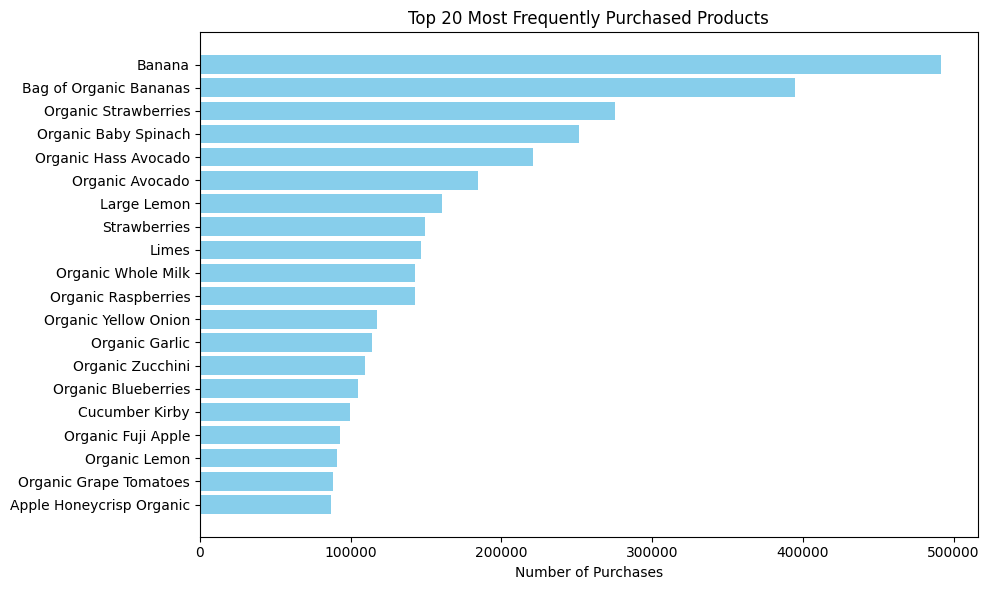

In [15]:
# Count product_id frequency in all orders
top_products = all_order_products['product_id'].value_counts().head(20).reset_index()
top_products.columns = ['product_id', 'count']

# Merge with products to get names
top_products = top_products.merge(products[['product_id', 'product_name']], on='product_id')

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_products['product_name'], top_products['count'], color='skyblue')
plt.xlabel("Number of Purchases")
plt.title("Top 20 Most Frequently Purchased Products")
plt.gca().invert_yaxis()  # So the most frequent is at the top
plt.tight_layout()
plt.show()

#### b. Number of Orders by Hour of Day 

Text(0, 0.5, 'Number of Orders')

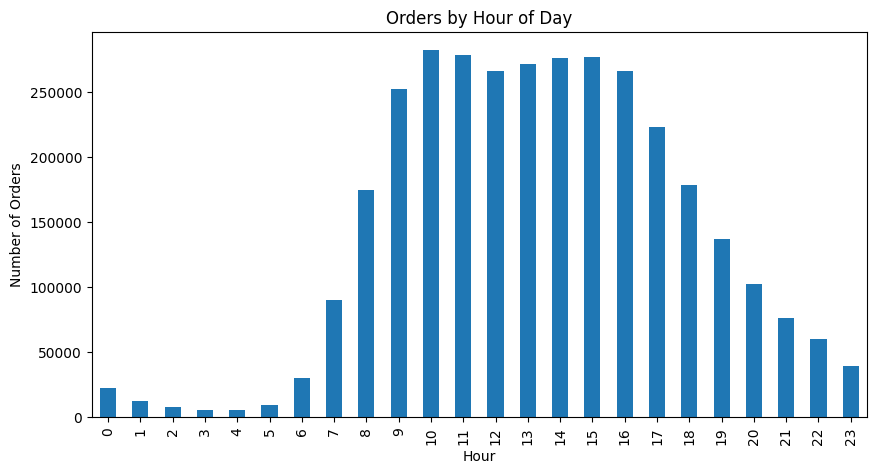

In [17]:
orders['order_hour'] = pd.to_datetime(orders['timestamp']).dt.hour
orders['order_hour'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5))
plt.title("Orders by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Orders")

#### c. Number of Orders per User and Average

In [19]:
order_counts = orders.groupby('user_id')['order_id'].count().reset_index()
order_counts.columns = ['user_id', 'num_orders']

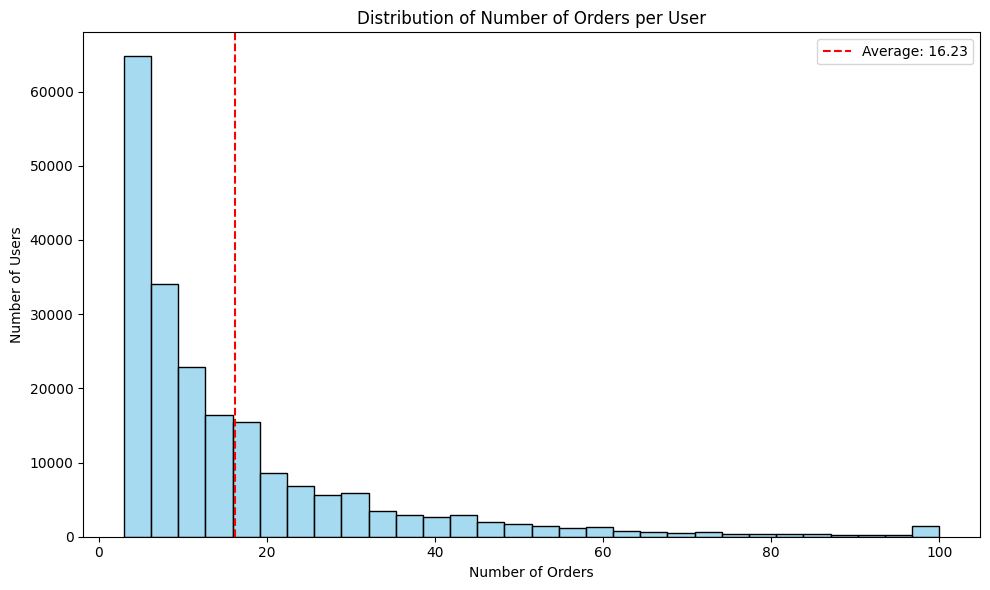

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(order_counts['num_orders'], bins=30, kde=False, color='skyblue', edgecolor='black')

# Add average line
avg_orders = order_counts['num_orders'].mean()
plt.axvline(avg_orders, color='red', linestyle='--', label=f'Average: {avg_orders:.2f}')

plt.title('Distribution of Number of Orders per User')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Users')
plt.legend()
plt.tight_layout()
plt.show()

* **Visualization c** gave us really important insights for this project - to consider user activity level.
* Users with *High/Low Activity Level* Overview:
|User Type| Pros | Cons |
|:----------|:------|:--------|
|**Below-Average Users** (Low Activity) | Helps improve cold-start/generalization; more realistic for new users| Sparse data |
|**Above-Average Users** (High Activity)| Rich behavioral data -> more accurate recommendations | Risk of overfitting to power users; less accurate for new users|


* So, if a goal is to:
    * Improve cold-start performance --> Prefer **Below-Average/Low Activity Users**
    * Maximize accuracy for active users (aka. personized marketing) --> Prefer **Above Average/High Activity Users**

### 2-3. Clean/Preprocess the Data

* Since we differentiate the high and low activity users, we will divide data based on this.
* I also removed products that are ordered less than 50 times.

In [23]:
# Separate users
high_activity_users = order_counts[order_counts['num_orders'] > avg_orders]['user_id']
low_activity_users = order_counts[order_counts['num_orders'] <= avg_orders]['user_id']

# Merge all_order_products with user_id
orders_with_user = orders[['order_id', 'user_id']]
aop_with_user = all_order_products.merge(orders_with_user, on='order_id')

# Filter orders based on user activity
high_activity_orders = aop_with_user[aop_with_user['user_id'].isin(high_activity_users)]
low_activity_orders = aop_with_user[aop_with_user['user_id'].isin(low_activity_users)]

# High-activity group
high_product_counts = high_activity_orders['product_id'].value_counts()
high_frequent_products = high_product_counts[high_product_counts > 50].index
high_activity_filtered_orders = high_activity_orders[high_activity_orders['product_id'].isin(high_frequent_products)]

# Low-activity group
low_product_counts = low_activity_orders['product_id'].value_counts()
low_frequent_products = low_product_counts[low_product_counts > 50].index
low_activity_filtered_orders = low_activity_orders[low_activity_orders['product_id'].isin(low_frequent_products)]

In [24]:
# Choose different activity group based on the goal
filtered_orders = low_activity_filtered_orders

filtered_orders.shape

(10627223, 4)

* **I chose to focus on low-activity users** because I want to explore patterns related to the cold start problem, and this also provides a good opportunity to practice working with sparse data.

## 3. Building and Training Models - Clustering

* Goal: Cluster shopping baskets (orders) based on products they contain, to discover customers' shopping patterns

### 3-1. Sample `order_id`s

* Since the dataset contains millions of rows, generating and processing the full matrix is computationally expensive. Therefore, I decided to work with a sample.
* Specifically, I sampled entire baskets (orders), rather than individual rows, in order to preserve realistic co-purchase patterns.

In [27]:
# Sample 100,000 unique orders
sample_order_ids = filtered_orders['order_id'].drop_duplicates().sample(n=100000, random_state=42)

# Filter the data to those orders
sampled_orders = filtered_orders[filtered_orders['order_id'].isin(sample_order_ids)]

### 3-2. Create Basket-Product Matrix

* Still takes 6~8 minutes

In [29]:
from scipy.sparse import csr_matrix

# Step 1: Create basket-product matrix with 0/1 values
basket_df = pd.crosstab(
    sampled_orders['order_id'],
    sampled_orders['product_id']
).gt(0).astype('int8')

# Step 2: Convert to sparse matrix
basket_sparse = csr_matrix(basket_df.values)

### 3-3. TruncatedSVD for reducing dimensionality

In [31]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

# Reduce dimensions
svd = TruncatedSVD(n_components=30, random_state=42)
basket_reduced = svd.fit_transform(basket_sparse)

### 3-4. PCA for Denoise

* Originally, I applied TruncatedSVD followed by KMeans, but the results were still affected by the curse of dimensionality.
* To address this, I added PCA as a preprocessing step to further reduce dimensionality and improve clustering performance.

In [33]:
from sklearn.decomposition import PCA

# Reduce SVD output to 10 components using PCA
pca = PCA(n_components=10, random_state=42)
basket_reduced = pca.fit_transform(basket_reduced)

### 3-5. KMeans Clustering

In [35]:
# Apply clustering
kmeans = KMeans(n_clusters=4, random_state=42) # n_cluster has been corrected after checking inertia
clusters = kmeans.fit_predict(basket_reduced)

In [36]:
# Attach cluster labels back to order IDs
cluster_df = pd.DataFrame({
    'order_id': sample_order_ids.values,
    'cluster': clusters
})

cluster_df.head()

,order_id,cluster
0,623812,0
1,2505214,0
2,1454664,2
3,3208482,0
4,2571503,0


## 4. Clustering Evaluation Metrics

### 4-1. Inertia
* First, we check Inertia (Sum of sqaured distance). Used in the **elbow method** to choose the right number of clusters.

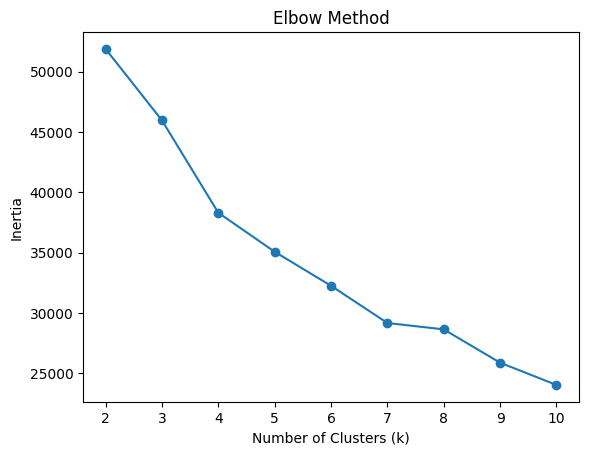

In [38]:
inertias = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(basket_reduced)
    inertias.append(km.inertia_)

# Plot
plt.plot(K, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

* Look for the “elbow” — where inertia stops decreasing rapidly. And that would be **k = 4**.
* You might see a sharp drop in WCSS from k=3 to k=4 (first elbow), and then another, less sharp drop from k=6 to k=7 (second elbow). This suggests that:
    * k=4: The data can be broadly grouped into four clusters.
    * k=7: Each of the initial four clusters might be further subdivided into smaller, more refined clusters.

### 4-2. Silhouette Score

* **Silhouette Score** is a metric used to evaluate the quality of clustering.
* The silhouette score for a single data point is calculated as:
    * $s = (b-a)/max(a,b)$
* Measures how well each sample fits within its cluster vs. others.
* Range: -1 to 1 (closer to 1 is better).

In [41]:
from sklearn.metrics import silhouette_score

score = silhouette_score(basket_reduced, clusters)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.5297


* A clustering with an average silhouette width of over $0.7$ is considered to be *"strong"*, a value over $0.5$ *"reasonable"* and over $0.25$ *"weak"*.
* However, a score above **0.2–0.3** is considered decent. Perfect separation is rare due to high dimensionality.
  

### 4-3. Top products in each Cluster

In [44]:
# Attach cluster labels
basket_df['cluster'] = clusters

# Map product IDs to names
product_id_to_name = products.set_index('product_id')['product_name'].to_dict()

# Loop through clusters and show product names
for i in range(kmeans.n_clusters):
    cluster_orders = basket_df[basket_df['cluster'] == i].drop(columns='cluster')
    top_products = cluster_orders.sum().sort_values(ascending=False).head(10)
    
    print(f"\nTop products in Cluster {i}:")
    for pid, count in top_products.items():
        pname = product_id_to_name.get(pid, "Unknown Product")
        print(f"{pname} (product_id={pid}): {count} orders")


Top products in Cluster 0:
Organic Strawberries (product_id=21137): 3264 orders
Large Lemon (product_id=47626): 2903 orders
Organic Avocado (product_id=47766): 2861 orders
Strawberries (product_id=16797): 2633 orders
Organic Hass Avocado (product_id=47209): 2594 orders
Limes (product_id=26209): 2481 orders
Organic Whole Milk (product_id=27845): 1778 orders
Organic Yellow Onion (product_id=22935): 1704 orders
Yellow Onions (product_id=4605): 1660 orders
Cucumber Kirby (product_id=49683): 1655 orders

Top products in Cluster 1:
Bag of Organic Bananas (product_id=13176): 8132 orders
Organic Strawberries (product_id=21137): 1108 orders
Organic Hass Avocado (product_id=47209): 1002 orders
Organic Raspberries (product_id=27966): 670 orders
Organic Blueberries (product_id=39275): 530 orders
Organic Avocado (product_id=47766): 528 orders
Organic Whole Milk (product_id=27845): 463 orders
Strawberries (product_id=16797): 433 orders
Organic Yellow Onion (product_id=22935): 431 orders
Apple Honey

* After examining the top products in each cluster, I noticed that some items appeared in multiple clusters. This isn’t surprising—using common sense—because these are grocery items, and there are certain essential products that many people purchase on a daily basis. **This observation led me to consider that removing such common items from the data might help produce clusters that are more clearly separated.**

### 4-4. Size of Clusters

cluster
0    72357
1     8132
2     7049
3    12462
Name: count, dtype: int64


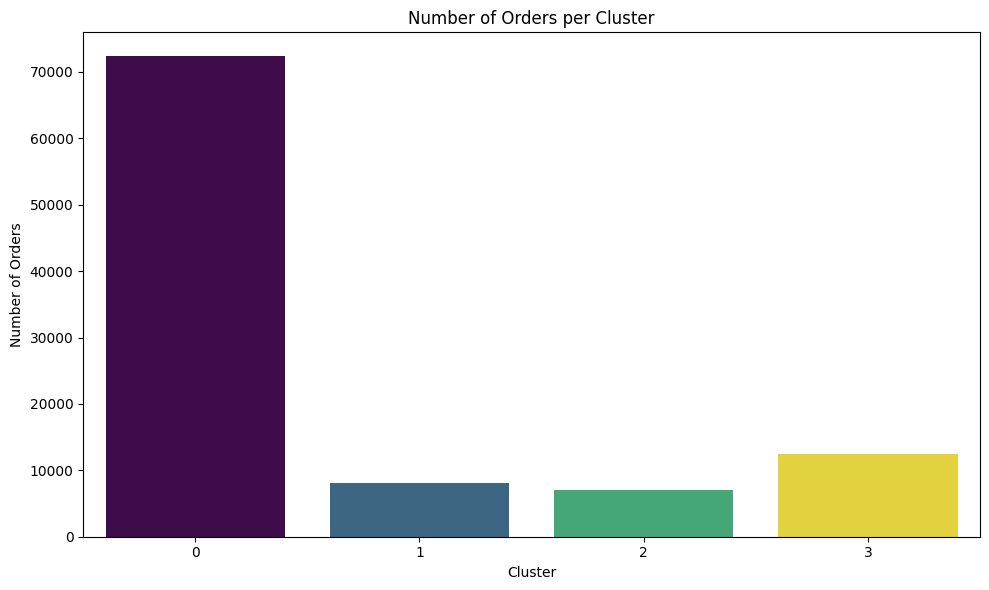

In [46]:
cluster_sizes = cluster_df['cluster'].value_counts().sort_index()
print(cluster_sizes)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette="viridis", hue=cluster_sizes.index, legend=False)

# Add labels and title
plt.xlabel('Cluster')
plt.ylabel('Number of Orders')
plt.title('Number of Orders per Cluster')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 5. Visualize Clusters

* t-SNE plot (2D): If clusters are visibly separate in this plot, that’s a strong sign the model captured meaningful structure.

In [48]:
# pip install openTSNE
# since sklearn TSNE takes too long
# openTSNE still take about 7 minutes though

In [49]:
from openTSNE import TSNE

tsne = TSNE(n_jobs=4, perplexity=30, random_state=42)
basket_2d = tsne.fit(basket_reduced)

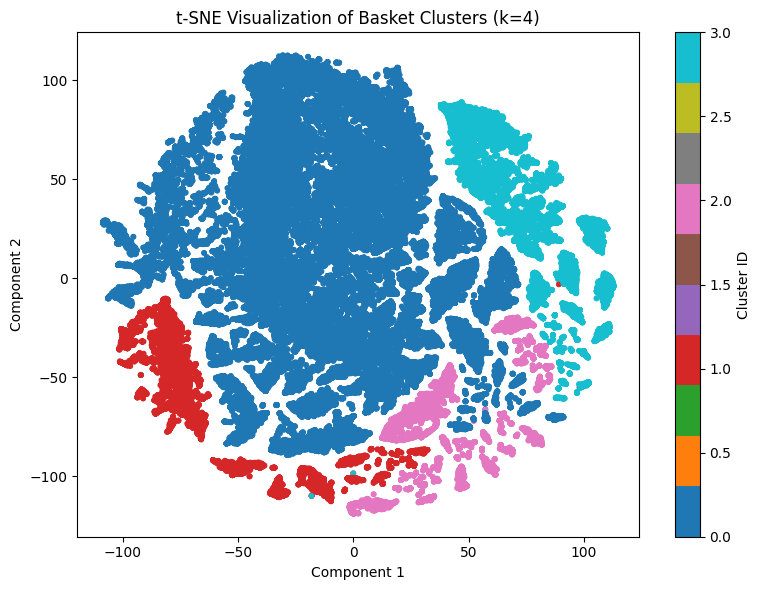

In [50]:
# Plot with cluster colors
plt.figure(figsize=(8,6))
plt.scatter(basket_2d[:, 0], basket_2d[:, 1], c=clusters, cmap='tab10', s=10)
plt.title("t-SNE Visualization of Basket Clusters (k=4)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label='Cluster ID')
plt.tight_layout()
plt.show()

* PCA (3D) plot

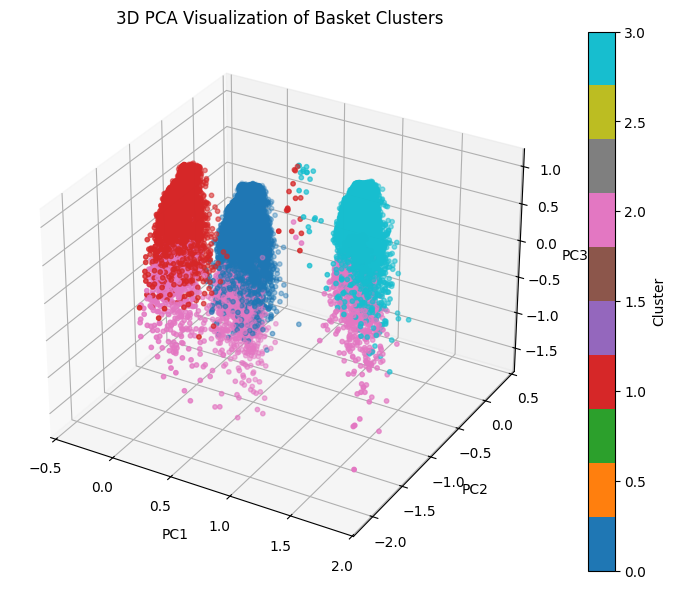

In [51]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3D
pca3d = PCA(n_components=3)
basket_3d = pca3d.fit_transform(basket_reduced)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(basket_3d[:, 0], basket_3d[:, 1], basket_3d[:, 2],
                     c=clusters, cmap='tab10', s=10)

ax.set_title("3D PCA Visualization of Basket Clusters")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.colorbar(scatter, label='Cluster')
plt.show()

## 6. Cluster-Based Recommendation

* Now we build Cluster-Based Recommendation which is suggesting products based on similar shopping behavior.
* Basically, we are recommending based on *simialr order patterns*:
    *  "This order is similar to Cluster 2"
    *  "People in cluster 2 also buy X, Y, Z."
    *  Therefore, recommend X, Y, Z.

<br>

* Steps to make this recommendation:
    1.  Take a new order (basket of product_ids)
    2.  Represent it using the same bakset-product format
    3.  Transform it using **TruncatedSVD --> PCA**
    4.  Assign it to a cluster using my trained **KMeans**
    5.  Recommend **Top N-products** from the cluster

In [53]:
# step 1: example product IDs in new order
new_order = [24852, 13176, 21137]  

# step 2: Create basket vector for the new order
# Same product_id order as used in training
product_columns = basket_df.drop(columns='cluster').columns

# Create 0/1 vector for the new order
new_vector = np.isin(product_columns, new_order).astype('int8').reshape(1, -1)

In [54]:
# step 3: Transform
new_svd = svd.transform(new_vector)
new_pca = pca.transform(new_svd)

In [55]:
# step 4: Assign the cluster
assigned_cluster = kmeans.predict(new_pca)[0]
print(f"New order assigned to Cluster {assigned_cluster}")

New order assigned to Cluster 1


In [56]:
# step 5: Recommend Top 5-products 
# Get all baskets in the assigned cluster
cluster_baskets = basket_df[basket_df['cluster'] == assigned_cluster].drop(columns='cluster')

# Sum product frequencies
top_products = cluster_baskets.sum().sort_values(ascending=False)

# Exclude products already in the order
recommendations = top_products[~top_products.index.isin(new_order)]

# Map product_id to names
product_id_to_name = products.set_index('product_id')['product_name'].to_dict()

# Print top N=5
top_n = 5
print(f"\nTop {top_n} product recommendations:")
for pid in recommendations.head(top_n).index:
    print(f"- {product_id_to_name.get(pid, 'Unknown Product')} (product_id={pid})")


Top 5 product recommendations:
- Organic Hass Avocado (product_id=47209)
- Organic Raspberries (product_id=27966)
- Organic Blueberries (product_id=39275)
- Organic Avocado (product_id=47766)
- Organic Whole Milk (product_id=27845)


<br>

## 7. Summary and Conclusion

#### 7-1. Project Overview
    The goal of this project was to develop a product recommendation system based on users' past orders using unsupervised learning techniques such as clustering and dimensionality reduction. Additionally, PCA is used for further preprocessing and visualization.


#### 7-2. Dataset and Preprocessing
    The dataset was a simplified version of the Instacart market basket data, containing over 3 million orders and 49,000 products. I focused on orders from low-activity users to address the cold-start problem and practiced handling sparse data by filtering infrequent products and reducing the order set.


#### 7-3. Modeling Approach
    To model the basket data, I created a binary basket-product matrix and applied TruncatedSVD to reduce dimensionality while preseving sparse structure. I then used PCA as an additional denoising step before clustering baskets with KMeans (k = 4).

#### 7-4. Evaluation - How the Clusters looked
    The clusters were evaluated using silhouette scores and visualized with 3D PCA. The silhouette score was 0.53, indicating moderate to strong separation between clusters - especially given the sparse nature of basket data.
    I analyzed the top products in each clusters to assess the interpretability, such as Cluster 0 has strong preference for fresh organic fruits and vegetables.
    The cluster sizes vary, with Cluster 0 being the largest and Cluster 1 the smallest. This suggests some imbalance, but the high silhouette score and clear differences among clusters has uncovered meaningful behavioural patterns.

#### 7-5. Recommendation Strategy
    I built a cluster-based recommendation system that assigns new orders to one of the learned clusters using the same transformation pipeline (SVD -> PCA -> KMeans). Recommendations are made by identifying popular products within the assigned cluster that user hasn't purchased yet.

#### 7-6. Key Findings
    1. While exploring the data during the EDA phase, I identified a useful strategy to segment users into high-activity and low-activity groups based on the number of orders per user. This decision was motivated by a desire to better understand cold-start behavior in recommendation systems and work effectively with sparse data.
    
    2. Due to the large size of the dataset (millions of records), it was not feasible to train machine learning models on the full dataset. I addressed this by using sampling techniques to reduce computational load while maintaining representativeness.
    
    3. To improve clustering performance, I applied PCA as a preprocessing step after TruncatedSVD. This significantly improved the silhouette score from 0.23 to 0.53, suggesting that PCA helped denoise the SVD output and made cluster boundaries more distinct.
    
    4. When analyzing the inertia plot for KMeans, I observed two elbows, indicating that each of the initial four clusters might be further subdivided into smaller, more refined clusters. This insight suggests that hierarchical clustering could be a valuable extension for uncovering nested customer behavior patterns.

#### 7-7. Limitaions
    1. Sampling was necessary, but it may have excluded rare user behaviors or niche product patterns.

    2. While I focused on low-activity users, the recommendation system does not yet personalize at the user level or account for time/context, which are important in real-world applications.

    3. Without user feedback or labels, evaluation is limited to internal metrics like silhouette score and product distribution analysis.

#### 7-8. Future Work
    1. Hierarchical Clustering: Since the inertia plot showed multiple elbows, suggesting potential substructure within clusters, applying hierarchical clustering could help reveal more granular segments and nested basket patterns that KMeans might have missed.
    
    2. Cold-Start Personalization: To better support new or low-activity users, future models could incorporate user-based collaborative filtering or content-based recommendation methods using product attributes, if available. This would enhance personalization beyond cluster-level patterns.

    3. Filtering Common Products to Improve Clarity: While analyzing cluster contents, I observed that certain frequently purchased items (e.g., bananas, milk) appeared across multiple clusters. This is understandable for essential grocery products, but it may obscure more specific shopping patterns. A promising next step would be to remove such common items prior to clustering in order to produce more distinct and interpretable clusters.